In [572]:
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import pylab as pl
import random

In [ ]:
TAM_IMAGE = 32
SCALING_LINES = 0.2
THRESHOLD = 0.5
DIFUSION_PARAMETER = 4
MINIMUM_CLUSTERS_SIZE = 15
d_0 = 10
theta_0 = np.pi / 6
delta = 1 / 4

In [574]:
def distance_perona(point_i, point_j):
    d_1 = -((point_j[0] - point_i[0])**2 + (point_j[1] - point_i[1])**2)/(d_0**2)
    d_2 = -(2 - np.cos(2 * point_i[2]) - np.cos(2 * point_j[2]))/(1 - np.cos(2 * theta_0))
    d_3 = -(1 - np.cos(2 * point_i[2] - 2 * point_j[2]))/(1 - np.cos(2 * delta * theta_0 ))
    return np.exp(d_1 + d_2 + d_3)

In [576]:
def random_points(prob_elim):
    points = []
    for x in range(TAM_IMAGE):
        for y in range(TAM_IMAGE):
            if(np.random.random() < prob_elim):
                continue
            else:
                points.append([x, y, np.random.random() * 2 * np.pi])
    return points

In [577]:
def affinity_matrix(points):
    A = []
    for point_i in points:
        array = []
        for point_j in points:
            array.append(distance_perona(point_i, point_j))
        A.append(array.copy())
    return np.asmatrix(A)

In [578]:
def degree_matrix(affinity_matrix):
    length = len(affinity_matrix)
    D = np.zeros((length, length))
    for x in range(length):
        sum = 0
        for y in range(length):
            sum += affinity_matrix[x,y]
        D[x][x] = sum
    return np.asmatrix(D)

In [579]:
def random_points_with_diagonal(prob_elim):
    points = random_points(prob_elim)
    points = [point for point in points if point[0] != point[1]]
    for i in range(TAM_IMAGE):
        points.append([i, i, np.pi / 4])
    return points

In [972]:
def spectral_clustering(points):
    # Paso 1
    A = affinity_matrix(points)
    
    # Paso 2
    D = degree_matrix(A)
    Lrw = np.matmul(np.linalg.inv(D), A)

    # Paso 3
    vals, vects = np.linalg.eig(Lrw)
    vects = vects.transpose()
    eig = [vals, vects]

    #Ordenamos los autovectores de manera decreciente:
    indices = list(range(len(eig[0])))
    indices.sort(key = eig[0].__getitem__, reverse=True)
    for i, sublist in enumerate(eig):
        eig[i] = [sublist[j] for j in indices]
        
    # Paso 5
    q = len(eig[0]) - 1
    for i in range(len(eig[0])):
        if((eig[0][i] ** DIFUSION_PARAMETER) < 1 - THRESHOLD):
            q = i - 1
            break
        
    # Paso 6
    clusters = []
    for i in range(q):
        clusters.append([])

    for i in range(len(points)):
        index_max = 0
        max = eig[1][0][0,i]
        for j in range(1,q):
            if(eig[1][j][0,i] > max):
                index_max = j
                max = eig[1][j][0,i]
        clusters[index_max].append(indices[i])
        
    print(q)
        
    # Paso 7
    alone_cluster = []
    for cluster in clusters:
        if(len(cluster) < MINIMUM_CLUSTERS_SIZE):
            alone_cluster += cluster
    clusters = [cluster for cluster in clusters if len(cluster) >= MINIMUM_CLUSTERS_SIZE]
    clusters = [alone_cluster] + clusters
    return clusters, indices

In [973]:
def print_image(points, clusters):
    lines = []
    for point in points:
        x = point[0]
        y = point[1]
        theta = point[2]
        cos = np.cos(theta)
        sen = np.sin(theta)
        lines.append([(x + SCALING_LINES * cos, y + SCALING_LINES * sen), 
                        (x - SCALING_LINES * cos, y - SCALING_LINES * sen)])
            
    colors_search = [[0,0,0,50]]
    for _ in range(len(clusters) - 1):
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        w = 1
        colors_search.append([r, g, b, w])        
    
    colors = []
    for i in range(len(points)):
        ind = [i in cluster for cluster in clusters].index(True)
        colors.append(colors_search[ind])

    # We need to set the plot limits.
    fig, ax = plt.subplots()
    ax.set_xlim(0 - 0.4, TAM_IMAGE + 0.2)
    ax.set_ylim(0 - 0.4, TAM_IMAGE + 0.2)
    
    line_segments = LineCollection(lines,
                               colors=colors, linestyle='solid')
    ax.add_collection(line_segments)
    ax.set_title('Line collection with masked arrays')
    plt.show()

In [1024]:
points = random_points_with_diagonal(0.85)
clusters, indices = spectral_clustering(points)

11


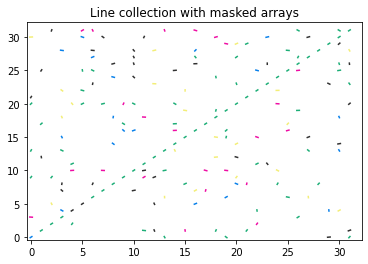

In [1030]:
print_image(points, clusters)